# Laydown Planner - Optimization
Optimizes object placement using 2D bin packing with category-based nesting and stacking.

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict
import ezdxf
import os

print('All imports successful!')

All imports successful!


## 2. Load Data

In [2]:
objects_df = pd.read_csv('../data/sample_objects.csv')

print(f'Loaded {len(objects_df)} object types')
print(f'\nCategories:')
print(objects_df['category'].value_counts())
print(f'\nStackable objects:')
print(objects_df[objects_df['stackable'] == True][['name', 'stackable', 'max_stack_height']])

Loaded 50 object types

Categories:
category
Category 1    19
Category 2    16
Category 3    15
Name: count, dtype: int64

Stackable objects:
         name  stackable  max_stack_height
0    Object A       True                10
1    Object B       True                 8
3    Object D       True                12
5    Object F       True                15
6    Object G       True                 9
8    Object I       True                11
10   Object K       True                13
11   Object L       True                 6
12   Object M       True                 8
14   Object O       True                10
15   Object P       True                 9
17   Object R       True                 8
19   Object T       True                 5
20   Object U       True                15
22   Object W       True                14
23   Object X       True                13
25   Object Z       True                12
26  Object AA       True                11
27  Object AB       True                1

### 2.5 Segregate by Category

In [3]:
# Category Segregation Rules
print("=== CATEGORY SEGREGATION CONFIGURATION ===\n")

categories = objects_df['category'].unique()
print(f"Available categories: {list(categories)}")

# Create default compatibility matrix (all compatible by default)
compatibility_matrix = {}
for cat1 in categories:
    compatibility_matrix[cat1] = {}
    for cat2 in categories:
        compatibility_matrix[cat1][cat2] = True  # True = can be together

print("\nDefault: All categories can share bins")
print("\nEnter segregation rules (separate with comma):")
print("Format: 'Category1,Category2' means they CANNOT share a bin")
print("Example: 'Steel,Wood,Concrete' means Steel-Wood and Steel-Concrete cannot mix")
print("(Type 'none' or just press Enter to skip)")

rule_input = input("\nSegregation rules: ").strip()

if rule_input.lower() != 'none' and rule_input:
    rules = [r.strip() for r in rule_input.split(',')]
    print(f"\nApplying rules: {rules}")
    
    # Mark incompatible pairs
    for i in range(len(rules)):
        for j in range(i + 1, len(rules)):
            cat1, cat2 = rules[i], rules[j]
            if cat1 in compatibility_matrix and cat2 in compatibility_matrix:
                compatibility_matrix[cat1][cat2] = False
                compatibility_matrix[cat2][cat1] = False
                print(f"  ✗ {cat1} cannot share bins with {cat2}")

# Display compatibility matrix
print("\n=== COMPATIBILITY MATRIX ===")
print(f"\n{'Category':<15}", end='')
for cat in categories:
    print(f"{cat:<15}", end='')
print()
print("-" * (15 + len(categories) * 15))

for cat1 in categories:
    print(f"{cat1:<15}", end='')
    for cat2 in categories:
        compatible = compatibility_matrix[cat1][cat2]
        symbol = "✓" if compatible else "✗"
        print(f"{symbol:<15}", end='')
    print()

print("\n✓ Segregation rules configured")

=== CATEGORY SEGREGATION CONFIGURATION ===

Available categories: ['Category 1', 'Category 2', 'Category 3']

Default: All categories can share bins

Enter segregation rules (separate with comma):
Format: 'Category1,Category2' means they CANNOT share a bin
Example: 'Steel,Wood,Concrete' means Steel-Wood and Steel-Concrete cannot mix
(Type 'none' or just press Enter to skip)

Applying rules: ['Category 1', 'Category 2']
  ✗ Category 1 cannot share bins with Category 2

=== COMPATIBILITY MATRIX ===

Category       Category 1     Category 2     Category 3     
------------------------------------------------------------
Category 1     ✓              ✗              ✓              
Category 2     ✗              ✓              ✓              
Category 3     ✓              ✓              ✓              

✓ Segregation rules configured


## 3. Define 2D Bin Packing Classes

In [7]:
class Rectangle:
    def __init__(self, width, length, obj_id, obj_name, category, weight, stackable=False, max_stack=1):
        self.width = width
        self.length = length
        self.obj_id = obj_id
        self.obj_name = obj_name
        self.category = category
        self.weight = weight
        self.stackable = stackable
        self.max_stack = max_stack
        self.x = 0
        self.y = 0
        self.rotated = False
        self.stack_height = 1
    
    def get_width(self):
        return self.length if self.rotated else self.width
    
    def get_length(self):
        return self.width if self.rotated else self.length
    
    def area(self):
        return self.width * self.length
    
    def __repr__(self):
        return f"Rectangle({self.obj_name}, {self.width}x{self.length})"

print('✓ Rectangle class defined')

✓ Rectangle class defined


In [4]:
class Bin:
    def __init__(self, width, length, bin_id, min_spacing=0, compatibility_matrix=None):
        self.width = width
        self.length = length
        self.bin_id = bin_id
        self.rectangles = []
        self.min_spacing = min_spacing
        self.compatibility_matrix = compatibility_matrix or {}
    
    def can_fit(self, rect):
        for existing in self.rectangles:
            if self._overlaps(rect, existing):
                return False
        
        # Check compatibility
        if self.compatibility_matrix:
            for existing in self.rectangles:
                if not self.compatibility_matrix.get(rect.category, {}).get(existing.category, True):
                    return False
        
        # Check if rect fits in bin with spacing
        if rect.x + rect.get_width() + self.min_spacing > self.width:
            return False
        if rect.y + rect.get_length() + self.min_spacing > self.length:
            return False
        
        return True
    
    def can_accept_category(self, category):
        """Check if this bin can accept a new category."""
        if not self.rectangles:
            return True
        
        if not self.compatibility_matrix:
            return True
        
        # Check compatibility with all existing categories in bin
        existing_categories = set(rect.category for rect in self.rectangles)
        
        for existing_cat in existing_categories:
            if not self.compatibility_matrix.get(category, {}).get(existing_cat, True):
                return False
        
        return True
    
    def _overlaps(self, rect1, rect2):
        return not (rect1.x + rect1.get_width() + self.min_spacing <= rect2.x or 
                   rect1.x >= rect2.x + rect2.get_width() + self.min_spacing or
                   rect1.y + rect1.get_length() + self.min_spacing <= rect2.y or 
                   rect1.y >= rect2.y + rect2.get_length() + self.min_spacing)

print('✓ Bin class updated with segregation support')

✓ Bin class updated with segregation support


## 4. Implement Packing Algorithm

In [8]:
def pack_objects(objects_df, bin_width=100, bin_length=100, min_spacing=0, compatibility_matrix=None):
    """
    Pack objects using 2D bin packing with segregation rules.
    Process ALL objects together instead of by category.
    """
    print(f"\nProcessing ALL objects with segregation rules...")
    
    # Create rectangles for ALL objects (not by category)
    rects = []
    for _, row in objects_df.iterrows():
        rect = Rectangle(
            width=float(row['width']),
            length=float(row['length']),
            obj_id=row['object_id'],
            obj_name=row['name'],
            category=row['category'],
            weight=float(row['weight']),
            stackable=row['stackable'] in [True, 'True', 'TRUE'],
            max_stack=int(row['max_stack_height'])
        )
        rects.append(rect)
    
    # Sort by area (largest first)
    rects.sort(key=lambda r: r.area(), reverse=True)
    
    # Pack into bins
    bins = []
    
    for rect in rects:
        placed = False
        
        # Try to stack on existing object of same type
        if rect.stackable:
            for bin_obj in bins:
                for existing in bin_obj.rectangles:
                    if (existing.obj_id == rect.obj_id and 
                        existing.stack_height < existing.max_stack):
                        # Check compatibility
                        if compatibility_matrix:
                            if not compatibility_matrix.get(rect.category, {}).get(existing.category, True):
                                continue
                        
                        # Stack on top
                        rect.x = existing.x
                        rect.y = existing.y
                        rect.stack_height = existing.stack_height + 1
                        existing.stack_height = rect.stack_height
                        bin_obj.rectangles.append(rect)
                        placed = True
                        print(f"  Stacked: {rect.obj_name} ({rect.category})")
                        break
                if placed:
                    break
        
        # If not stacked, try to fit in existing bin
        if not placed:
            for bin_obj in bins:
                # Check if this category can go in this bin
                if compatibility_matrix:
                    if not bin_obj.can_accept_category(rect.category):
                        continue
                
                # Try different positions
                positions_to_try = [(0, 0)]
                for existing in bin_obj.rectangles:
                    positions_to_try.append((existing.x + existing.get_width() + min_spacing, existing.y))
                    positions_to_try.append((existing.x, existing.y + existing.get_length() + min_spacing))
                
                for x, y in positions_to_try:
                    # Try normal orientation
                    rect.x = x
                    rect.y = y
                    rect.rotated = False
                    
                    # Check if fits with spacing
                    fits = True
                    if rect.x + rect.get_width() + min_spacing > bin_obj.width:
                        fits = False
                    if rect.y + rect.get_length() + min_spacing > bin_obj.length:
                        fits = False
                    
                    # Check overlap
                    if fits:
                        for existing in bin_obj.rectangles:
                            if bin_obj._overlaps(rect, existing):
                                fits = False
                                break
                    
                    if fits:
                        bin_obj.rectangles.append(rect)
                        placed = True
                        break
                    
                    # Try rotated orientation
                    rect.rotated = True
                    fits = True
                    if rect.x + rect.get_width() + min_spacing > bin_obj.width:
                        fits = False
                    if rect.y + rect.get_length() + min_spacing > bin_obj.length:
                        fits = False
                    
                    if fits:
                        for existing in bin_obj.rectangles:
                            if bin_obj._overlaps(rect, existing):
                                fits = False
                                break
                    
                    if fits:
                        bin_obj.rectangles.append(rect)
                        placed = True
                        break
                    
                    rect.rotated = False
                
                if placed:
                    break
        
        # Create new bin if needed
        if not placed:
            new_bin = Bin(bin_width, bin_length, len(bins), min_spacing=min_spacing, 
                         compatibility_matrix=compatibility_matrix)
            rect.x = 0
            rect.y = 0
            rect.rotated = False
            
            if (rect.get_width() + min_spacing <= new_bin.width and
                rect.get_length() + min_spacing <= new_bin.length):
                new_bin.rectangles.append(rect)
                bins.append(new_bin)
                placed = True
            else:
                rect.rotated = True
                if (rect.get_width() + min_spacing <= new_bin.width and
                    rect.get_length() + min_spacing <= new_bin.length):
                    new_bin.rectangles.append(rect)
                    bins.append(new_bin)
                    placed = True
        
        if not placed:
            print(f"  WARNING: Could not place {rect.obj_name}")
    
    print(f"  ✓ Created {len(bins)} bins total")
    return bins

print('✓ Packing algorithm updated (processes ALL objects together)')

✓ Packing algorithm updated (processes ALL objects together)


### Testing..

In [ ]:
# First, let's see what dimensions we're working with
print("=== OBJECT DIMENSIONS ===")
print(f"Width - Min: {objects_df['width'].min()}, Max: {objects_df['width'].max()}")
print(f"Length - Min: {objects_df['length'].min()}, Max: {objects_df['length'].max()}")

print(f"\nObject areas:")
objects_df['area'] = objects_df['width'] * objects_df['length']
print(objects_df[['name', 'width', 'length', 'area']].sort_values('area', ascending=False).head(10))

# Calculate appropriate bin size
max_width = objects_df['width'].max()
max_length = objects_df['length'].max()
suggested_bin_width = max_width * 1.5
suggested_bin_length = max_length * 1.5

print(f"\nSuggested bin size: {suggested_bin_width} x {suggested_bin_length}")

### 4.5 Space between objects

In [ ]:
# User input for minimum spacing
spacing_input = input(f"Enter minimum spacing between objects (default 0): ").strip()

try:
    min_spacing = float(spacing_input) if spacing_input else 0
except ValueError:
    print("Invalid input! Using default: 0")
    min_spacing = 0

print(f"✓ Using minimum spacing: {min_spacing}")

### 4.9 Affect Bin Size

In [ ]:
# User input for bin dimensions
print("=== BIN CONFIGURATION ===")
print(f"Current object dimensions:")
print(f"  Width range: {objects_df['width'].min()} - {objects_df['width'].max()}")
print(f"  Length range: {objects_df['length'].min()} - {objects_df['length'].max()}")

# Get user input
bin_width_input = input(f"Enter bin width (default 350): ").strip()
bin_length_input = input(f"Enter bin length (default 1100): ").strip()

# Parse inputs with defaults
try:
    bin_width = float(bin_width_input) if bin_width_input else 350
    bin_length = float(bin_length_input) if bin_length_input else 1100
except ValueError:
    print("Invalid input! Using defaults: 350 x 1100")
    bin_width = 350
    bin_length = 1100

print(f"\n✓ Using bin size: {bin_width} x {bin_length}")

## 5. Generate Optimized Laydown Plan

In [9]:
# User input for bin dimensions
print("=== BIN CONFIGURATION ===")
print(f"Current object dimensions:")
print(f"  Width range: {objects_df['width'].min()} - {objects_df['width'].max()}")
print(f"  Length range: {objects_df['length'].min()} - {objects_df['length'].max()}")

bin_width_input = input(f"Enter bin width (default 350): ").strip()
bin_length_input = input(f"Enter bin length (default 1100): ").strip()

try:
    bin_width = float(bin_width_input) if bin_width_input else 350
    bin_length = float(bin_length_input) if bin_length_input else 1100
except ValueError:
    print("Invalid input! Using defaults: 350 x 1100")
    bin_width = 350
    bin_length = 1100

print(f"\n✓ Using bin size: {bin_width} x {bin_length}")

# User input for minimum spacing
spacing_input = input(f"Enter minimum spacing between objects (default 0): ").strip()

try:
    min_spacing = float(spacing_input) if spacing_input else 0
except ValueError:
    print("Invalid input! Using default: 0")
    min_spacing = 0

print(f"✓ Using minimum spacing: {min_spacing}")

# Pack with segregation rules
bins = pack_objects(objects_df, bin_width=bin_width, bin_length=bin_length, min_spacing=min_spacing, compatibility_matrix=compatibility_matrix)

print(f'\n✓ Packing complete')
print(f'Total bins needed: {len(bins)}')
print(f'Total objects packed: {sum(len(bin.rectangles) for bin in bins)}')

for i, bin_obj in enumerate(bins):
    total_area = sum(rect.area() for rect in bin_obj.rectangles)
    utilization = (total_area / (bin_obj.width * bin_obj.length)) * 100
    categories_in_bin = set(rect.category for rect in bin_obj.rectangles)
    print(f'\nBin {i}: {len(bin_obj.rectangles)} objects, {utilization:.1f}% utilization')
    print(f'  Categories: {", ".join(categories_in_bin)}')

=== BIN CONFIGURATION ===
Current object dimensions:
  Width range: 100 - 200
  Length range: 200 - 690

✓ Using bin size: 750.0 x 1500.0
✓ Using minimum spacing: 25.0

Processing ALL objects with segregation rules...
  ✓ Created 6 bins total

✓ Packing complete
Total bins needed: 6
Total objects packed: 50

Bin 0: 7 objects, 67.7% utilization
  Categories: Category 3, Category 2

Bin 1: 9 objects, 69.4% utilization
  Categories: Category 1, Category 3

Bin 2: 11 objects, 68.9% utilization
  Categories: Category 3, Category 2

Bin 3: 14 objects, 66.4% utilization
  Categories: Category 1, Category 3

Bin 4: 8 objects, 30.7% utilization
  Categories: Category 3, Category 2

Bin 5: 1 objects, 3.4% utilization
  Categories: Category 1


### 5.5 Visualize the Plan

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Visualize bins
fig, axes = plt.subplots(len(bins), 1, figsize=(14, 5*len(bins)))

# Handle single bin case
if len(bins) == 1:
    axes = [axes]

# Color map for categories
categories = objects_df['category'].unique()
color_map = {cat: plt.cm.Set3(i) for i, cat in enumerate(categories)}

for bin_idx, bin_obj in enumerate(bins):
    ax = axes[bin_idx]
    
    # Draw bin boundary
    bin_rect = patches.Rectangle((0, 0), bin_obj.width, bin_obj.length, 
                                  linewidth=3, edgecolor='black', facecolor='none')
    ax.add_patch(bin_rect)
    
    # Draw objects
    stack_offset = {}
    for rect in bin_obj.rectangles:
        # Calculate stack offset
        key = (rect.x, rect.y)
        if key not in stack_offset:
            stack_offset[key] = 0
        offset = stack_offset[key]
        stack_offset[key] += 2
        
        # Get color based on category
        color = color_map.get(rect.category, 'gray')
        
        # Draw rectangle with offset for stacked items
        x = rect.x + offset
        y = rect.y + offset
        w = rect.get_width()
        l = rect.get_length()
        
        obj_rect = patches.Rectangle((x, y), w, l, 
                                     linewidth=1.5, edgecolor='black', 
                                     facecolor=color, alpha=0.7)
        ax.add_patch(obj_rect)
        
        # Add label
        label = f"{rect.obj_name}\n{rect.weight}kg"
        if rect.stack_height > 1:
            label += f"\n(x{rect.stack_height})"
        
        ax.text(x + w/2, y + l/2, label, ha='center', va='center', 
               fontsize=7, fontweight='bold')
    
    # Customize axis
    ax.set_xlim(-10, bin_obj.width + 10)
    ax.set_ylim(-10, bin_obj.length + 10)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Width', fontsize=10)
    ax.set_ylabel('Length', fontsize=10)
    
    # Calculate utilization
    total_area = sum(rect.area() for rect in bin_obj.rectangles)
    utilization = (total_area / (bin_obj.width * bin_obj.length)) * 100
    
    ax.set_title(f'Bin {bin_idx} - {len(bin_obj.rectangles)} objects, {utilization:.1f}% utilization', 
                fontsize=12, fontweight='bold')

# Add legend
legend_elements = [patches.Patch(facecolor=color_map[cat], label=cat) 
                  for cat in sorted(categories)]
fig.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print('✓ Visualization complete')

In [ ]:
print("=== DEBUGGING PACKING ===")
print(f"\nObjects DataFrame shape: {objects_df.shape}")
print(f"Objects DataFrame columns: {objects_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(objects_df.head())

print(f"\nData types:")
print(objects_df.dtypes)

print(f"\nUnique categories: {objects_df['category'].unique()}")
print(f"Number of categories: {objects_df['category'].nunique()}")

# Check for NaN values
print(f"\nMissing values:")
print(objects_df.isnull().sum())

# Try packing with verbose output
print("\n=== ATTEMPTING PACK ===")
try:
    bins = pack_objects(objects_df, bin_width=100, bin_length=100)
    print(f"Packing successful! Created {len(bins)} bins")
    for i, bin_obj in enumerate(bins):
        print(f"  Bin {i}: {len(bin_obj.rectangles)} objects")
except Exception as e:
    print(f"Packing failed: {e}")
    import traceback
    traceback.print_exc()

## 6. Generate DXF from Optimized Plan

In [ ]:
from ezdxf.enums import TextEntityAlignment

doc = ezdxf.new()
msp = doc.modelspace()

y_offset = 0
for bin_idx, bin_obj in enumerate(bins):
    bin_x = 0
    bin_y = y_offset
    
    # Draw bin boundary
    msp.add_lwpolyline([
        (bin_x, bin_y), 
        (bin_x + bin_obj.width, bin_y), 
        (bin_x + bin_obj.width, bin_y + bin_obj.length), 
        (bin_x, bin_y + bin_obj.length), 
        (bin_x, bin_y)
    ], close=True)
    
    stack_offset = {}
    for rect in bin_obj.rectangles:
        key = (rect.x, rect.y)
        if key not in stack_offset:
            stack_offset[key] = 0
        offset = stack_offset[key]
        stack_offset[key] += 0.5
        
        x = bin_x + rect.x + offset
        y = bin_y + rect.y + offset
        w = rect.get_width()
        l = rect.get_length()
        
        # Draw rectangle
        msp.add_lwpolyline([
            (x, y), 
            (x + w, y), 
            (x + w, y + l), 
            (x, y + l), 
            (x, y)
        ], close=True)
        
        # Add MTEXT with multi-line formatting
        label = f"{rect.obj_name}\\P{rect.weight}kg"
        if rect.stack_height > 1:
            label += f"\\P(Stack: {rect.stack_height}x)"
        
        mtext = msp.add_mtext(label, dxfattribs={'char_height': 2})
        mtext.set_location((x + w/2, y + l/2),None,5)
    
    y_offset += bin_obj.length + 5

# Save DXF
os.makedirs('../data', exist_ok=True)
doc.saveas('../data/optimized_laydown.dxf')

print('✓ DXF generated: data/optimized_laydown.dxf')

## 7. Summary

In [ ]:
print('=== OPTIMIZATION SUMMARY ===')
print(f'Total objects: {len(objects_df)}')
print(f'Total bins created: {len(bins)}')
print(f'\nBin Details:')
for i, bin_obj in enumerate(bins):
    stacked = sum(1 for rect in bin_obj.rectangles if rect.stack_height > 1)
    print(f'  Bin {i}: {len(bin_obj.rectangles)} items, {stacked} stacks')
print('✓ Optimization complete!')

## 8. Genetic Algorithm

In [10]:
import random
import numpy as np
from copy import deepcopy

class GeneticAlgorithmPacker:
    """
    Genetic Algorithm for 2D bin packing optimization.
    Evolves solutions to find near-optimal packings.
    """
    
    def __init__(self, population_size=50, generations=20, mutation_rate=0.1, crossover_rate=0.8):
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.best_solutions = []
    
    def pack_objects_ga(self, objects_df, bin_width=350, bin_length=1100, min_spacing=0, compatibility_matrix=None):
        """
        Use genetic algorithm to find optimal packing with segregation rules.
        """
        # Prepare objects (ALL objects, not by category)
        all_rectangles = []
        
        for _, row in objects_df.iterrows():
            rect = Rectangle(
                width=float(row['width']),
                length=float(row['length']),
                obj_id=row['object_id'],
                obj_name=row['name'],
                category=row['category'],
                weight=float(row['weight']),
                stackable=row['stackable'] in [True, 'True', 'TRUE'],
                max_stack=int(row['max_stack_height'])
            )
            all_rectangles.append(rect)
        
        print(f"\n=== GENETIC ALGORITHM PACKING ===")
        print(f"Population size: {self.population_size}")
        print(f"Generations: {self.generations}")
        print(f"Objects to pack: {len(all_rectangles)}")
        
        # Initialize population (random orderings)
        population = [random.sample(all_rectangles, len(all_rectangles)) 
                     for _ in range(self.population_size)]
        
        best_fitness = float('inf')
        best_solution = None
        
        for generation in range(self.generations):
            fitnesses = []
            solutions = []
            
            for solution in population:
                bins = self._pack_from_ordering(solution, bin_width, bin_length, min_spacing, compatibility_matrix)
                fitness = self._calculate_fitness(bins)
                fitnesses.append(fitness)
                solutions.append((fitness, bins, solution))
            
            solutions.sort(key=lambda x: x[0])
            best_gen_fitness = solutions[0][0]
            
            if best_gen_fitness < best_fitness:
                best_fitness = best_gen_fitness
                best_solution = solutions[0]
                print(f"  Gen {generation + 1}: Fitness = {best_fitness:.2f} (Bins: {len(best_solution[1])})")
            else:
                print(f"  Gen {generation + 1}: Fitness = {best_gen_fitness:.2f} (Bins: {len(solutions[0][1])})")
            
            # Selection: keep top 20%
            elite_size = max(1, self.population_size // 5)
            elite = [solutions[i][2] for i in range(elite_size)]
            
            # Create new population
            new_population = elite[:]
            
            while len(new_population) < self.population_size:
                parent1 = self._tournament_selection(solutions)
                parent2 = self._tournament_selection(solutions)
                
                if random.random() < self.crossover_rate:
                    child1, child2 = self._crossover(parent1, parent2)
                else:
                    child1, child2 = deepcopy(parent1), deepcopy(parent2)
                
                if random.random() < self.mutation_rate:
                    child1 = self._mutate(child1)
                if random.random() < self.mutation_rate:
                    child2 = self._mutate(child2)
                
                new_population.append(child1)
                if len(new_population) < self.population_size:
                    new_population.append(child2)
            
            population = new_population[:self.population_size]
        
        print(f"\n✓ GA Complete: {len(best_solution[1])} bins, Fitness: {best_fitness:.2f}")
        self.best_solutions.append((best_fitness, best_solution[1]))
        
        return best_solution[1]
    
    def _pack_from_ordering(self, ordering, bin_width, bin_length, min_spacing, compatibility_matrix=None):
        """Pack objects using a specific ordering, respecting segregation rules."""
        bins = []
        
        for rect in ordering:
            placed = False
            
            # Try existing bins
            for bin_obj in bins:
                # Check segregation rules first
                if compatibility_matrix:
                    if not bin_obj.can_accept_category(rect.category):
                        continue
                
                positions = [(0, 0)]
                for existing in bin_obj.rectangles:
                    positions.append((existing.x + existing.get_width() + min_spacing, existing.y))
                    positions.append((existing.x, existing.y + existing.get_length() + min_spacing))
                
                for x, y in positions:
                    rect.x = x
                    rect.y = y
                    rect.rotated = False
                    
                    if (rect.x + rect.get_width() + min_spacing <= bin_width and
                        rect.y + rect.get_length() + min_spacing <= bin_length):
                        
                        overlaps = False
                        for existing in bin_obj.rectangles:
                            if bin_obj._overlaps(rect, existing):
                                overlaps = True
                                break
                        
                        if not overlaps:
                            bin_obj.rectangles.append(deepcopy(rect))
                            placed = True
                            break
                    
                    rect.rotated = True
                    if (rect.x + rect.get_width() + min_spacing <= bin_width and
                        rect.y + rect.get_length() + min_spacing <= bin_length):
                        
                        overlaps = False
                        for existing in bin_obj.rectangles:
                            if bin_obj._overlaps(rect, existing):
                                overlaps = True
                                break
                        
                        if not overlaps:
                            bin_obj.rectangles.append(deepcopy(rect))
                            placed = True
                            break
                    
                    rect.rotated = False
                
                if placed:
                    break
            
            # Create new bin if needed
            if not placed:
                new_bin = Bin(bin_width, bin_length, len(bins), min_spacing=min_spacing,
                             compatibility_matrix=compatibility_matrix)
                rect.x = 0
                rect.y = 0
                rect.rotated = False
                new_bin.rectangles.append(deepcopy(rect))
                bins.append(new_bin)
        
        return bins
    
    def _calculate_fitness(self, bins):
        """
        Calculate fitness score (lower is better).
        Considers: number of bins, utilization, weight distribution
        """
        num_bins = len(bins)
        total_utilization = 0
        
        for bin_obj in bins:
            if len(bin_obj.rectangles) > 0:
                total_area = sum(rect.area() for rect in bin_obj.rectangles)
                bin_area = bin_obj.width * bin_obj.length
                utilization = total_area / bin_area
                total_utilization += utilization
        
        avg_utilization = total_utilization / len(bins) if bins else 0
        
        # Fitness = bins (primary) + (1 - utilization) (secondary)
        fitness = num_bins + (1 - avg_utilization) * 0.5
        
        return fitness
    
    def _tournament_selection(self, solutions, tournament_size=3):
        """Select best solution from random tournament."""
        tournament = random.sample(solutions, min(tournament_size, len(solutions)))
        tournament.sort(key=lambda x: x[0])
        return deepcopy(tournament[0][2])
    
    def _crossover(self, parent1, parent2):
        """Order Crossover (OX) for permutations."""
        size = len(parent1)
        start = random.randint(0, size - 2)
        end = random.randint(start + 1, size - 1)
        
        child1 = parent1[:]
        child2 = parent2[:]
        
        # Copy segment
        segment1 = parent1[start:end]
        segment2 = parent2[start:end]
        
        # Fill rest with remaining elements in order
        def fill_child(child, segment, other_parent):
            used = set(segment)
            pos = end
            for item in other_parent[end:] + other_parent[:end]:
                if item not in used:
                    if pos >= len(child):
                        pos = 0
                    child[pos] = item
                    pos += 1
            return child
        
        child1[start:end] = segment2
        child2[start:end] = segment1
        
        return child1, child2
    
    def _mutate(self, solution):
        """Swap mutation: swap two random elements."""
        solution = deepcopy(solution)
        idx1, idx2 = random.sample(range(len(solution)), 2)
        solution[idx1], solution[idx2] = solution[idx2], solution[idx1]
        return solution

print('✓ Genetic Algorithm Packer defined (with segregation support)')

✓ Genetic Algorithm Packer defined (with segregation support)


### 8.5 Execute Genetic Algorithm

In [11]:
# Use Genetic Algorithm for packing
use_ga = input("Use Genetic Algorithm for better packing? (y/n, default n): ").strip().lower()

if use_ga == 'y':
    ga_packer = GeneticAlgorithmPacker(
        population_size=50,      # Number of solutions per generation
        generations=20,          # Number of generations to evolve
        mutation_rate=0.1,       # 10% chance to mutate
        crossover_rate=0.8       # 80% chance to crossover
    )
    
    bins = ga_packer.pack_objects_ga(objects_df, bin_width=bin_width, bin_length=bin_length, min_spacing=min_spacing)
    print(f"\n✓ GA Packing complete: {len(bins)} bins")
else:
    # Use regular packing
    bins = pack_objects(objects_df, bin_width=bin_width, bin_length=bin_length, min_spacing=min_spacing)
    print(f"\n✓ Standard packing complete: {len(bins)} bins")

print(f'Total objects packed: {sum(len(bin.rectangles) for bin in bins)}')

for i, bin_obj in enumerate(bins):
    total_area = sum(rect.area() for rect in bin_obj.rectangles)
    utilization = (total_area / (bin_obj.width * bin_obj.length)) * 100
    print(f'Bin {i}: {len(bin_obj.rectangles)} objects, {utilization:.1f}% utilization')


=== GENETIC ALGORITHM PACKING ===
Population size: 50
Generations: 20
Objects to pack: 50
  Gen 1: Fitness = 5.19 (Bins: 5)
  Gen 2: Fitness = 5.16 (Bins: 5)
  Gen 3: Fitness = 5.16 (Bins: 5)
  Gen 4: Fitness = 5.16 (Bins: 5)
  Gen 5: Fitness = 5.16 (Bins: 5)
  Gen 6: Fitness = 5.16 (Bins: 5)
  Gen 7: Fitness = 5.16 (Bins: 5)
  Gen 8: Fitness = 5.16 (Bins: 5)
  Gen 9: Fitness = 5.16 (Bins: 5)
  Gen 10: Fitness = 5.16 (Bins: 5)
  Gen 11: Fitness = 5.16 (Bins: 5)
  Gen 12: Fitness = 5.16 (Bins: 5)
  Gen 13: Fitness = 5.16 (Bins: 5)
  Gen 14: Fitness = 5.16 (Bins: 5)
  Gen 15: Fitness = 5.16 (Bins: 5)
  Gen 16: Fitness = 5.16 (Bins: 5)
  Gen 17: Fitness = 5.16 (Bins: 5)
  Gen 18: Fitness = 5.16 (Bins: 5)
  Gen 19: Fitness = 5.16 (Bins: 5)
  Gen 20: Fitness = 5.16 (Bins: 5)

✓ GA Complete: 5 bins, Fitness: 5.16

✓ GA Packing complete: 5 bins
Total objects packed: 50
Bin 0: 13 objects, 73.0% utilization
Bin 1: 11 objects, 64.7% utilization
Bin 2: 9 objects, 70.3% utilization
Bin 3: 10 obje

## 9. Compare

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Run both algorithms and compare
print("=== COMPARING PACKING ALGORITHMS ===\n")

# Standard packing
print("1. Running STANDARD GREEDY packing...")
bins_standard = pack_objects(objects_df, bin_width=bin_width, bin_length=bin_length, min_spacing=min_spacing, compatibility_matrix=compatibility_matrix)

standard_metrics = {
    'num_bins': len(bins_standard),
    'total_objects': sum(len(bin.rectangles) for bin in bins_standard),
    'avg_utilization': np.mean([
        sum(rect.area() for rect in bin.rectangles) / (bin.width * bin.length) 
        for bin in bins_standard
    ]) * 100,
    'total_area_used': sum(sum(rect.area() for rect in bin.rectangles) for bin in bins_standard),
    'total_weight': sum(sum(rect.weight for rect in bin.rectangles) for bin in bins_standard)
}

print(f"  ✓ Standard: {standard_metrics['num_bins']} bins, {standard_metrics['avg_utilization']:.1f}% utilization\n")

# Genetic Algorithm packing
print("2. Running GENETIC ALGORITHM packing...")
ga_packer = GeneticAlgorithmPacker(population_size=50, generations=20, mutation_rate=0.1, crossover_rate=0.8)
bins_ga = ga_packer.pack_objects_ga(objects_df, bin_width=bin_width, bin_length=bin_length, min_spacing=min_spacing, compatibility_matrix=compatibility_matrix)
ga_metrics = {
    'num_bins': len(bins_ga),
    'total_objects': sum(len(bin.rectangles) for bin in bins_ga),
    'avg_utilization': np.mean([
        sum(rect.area() for rect in bin.rectangles) / (bin.width * bin.length) 
        for bin in bins_ga
    ]) * 100,
    'total_area_used': sum(sum(rect.area() for rect in bin.rectangles) for bin in bins_ga),
    'total_weight': sum(sum(rect.weight for rect in bin.rectangles) for bin in bins_ga)
}

print(f"  ✓ GA: {ga_metrics['num_bins']} bins, {ga_metrics['avg_utilization']:.1f}% utilization\n")

# Calculate improvements
improvement_bins = ((standard_metrics['num_bins'] - ga_metrics['num_bins']) / standard_metrics['num_bins']) * 100
improvement_util = ga_metrics['avg_utilization'] - standard_metrics['avg_utilization']

print("=" * 60)
print("COMPARISON RESULTS")
print("=" * 60)
print(f"\n{'Metric':<30} {'Standard':<15} {'Genetic Algo':<15}")
print("-" * 60)
print(f"{'Number of Bins':<30} {standard_metrics['num_bins']:<15} {ga_metrics['num_bins']:<15}")
print(f"{'Objects Packed':<30} {standard_metrics['total_objects']:<15} {ga_metrics['total_objects']:<15}")
print(f"{'Avg Utilization':<30} {standard_metrics['avg_utilization']:.1f}%{'':<10} {ga_metrics['avg_utilization']:.1f}%")
print(f"{'Total Weight (kg)':<30} {standard_metrics['total_weight']:<15.0f} {ga_metrics['total_weight']:<15.0f}")
print("-" * 60)
print(f"\n{'IMPROVEMENTS':<30}")
print(f"  • Bins reduced: {improvement_bins:.1f}%")
print(f"  • Utilization improved: {improvement_util:.1f}%")
if improvement_bins > 0:
    print(f"  • Cost savings: ~{improvement_bins:.1f}% fewer bins needed! 🎉")
else:
    print(f"  • Both algorithms found equivalent solutions")

print("\n" + "=" * 60)

# Store for visualization
bins_comparison = {
    'Standard': bins_standard,
    'Genetic Algorithm': bins_ga,
    'Standard Metrics': standard_metrics,
    'GA Metrics': ga_metrics
}

=== COMPARING PACKING ALGORITHMS ===

1. Running STANDARD GREEDY packing...

Processing ALL objects with segregation rules...
  ✓ Created 6 bins total
  ✓ Standard: 6 bins, 51.1% utilization

2. Running GENETIC ALGORITHM packing...

=== GENETIC ALGORITHM PACKING ===
Population size: 50
Generations: 20
Objects to pack: 50
  Gen 1: Fitness = 5.19 (Bins: 5)
  Gen 2: Fitness = 5.19 (Bins: 5)
  Gen 3: Fitness = 5.19 (Bins: 5)
  Gen 4: Fitness = 5.18 (Bins: 5)
  Gen 5: Fitness = 5.18 (Bins: 5)
  Gen 6: Fitness = 5.18 (Bins: 5)
  Gen 7: Fitness = 5.17 (Bins: 5)
  Gen 8: Fitness = 5.17 (Bins: 5)
  Gen 9: Fitness = 5.17 (Bins: 5)
  Gen 10: Fitness = 5.17 (Bins: 5)
  Gen 11: Fitness = 5.17 (Bins: 5)
  Gen 12: Fitness = 5.16 (Bins: 5)
  Gen 13: Fitness = 5.16 (Bins: 5)
  Gen 14: Fitness = 5.16 (Bins: 5)
  Gen 15: Fitness = 5.16 (Bins: 5)
  Gen 16: Fitness = 5.16 (Bins: 5)
  Gen 17: Fitness = 5.16 (Bins: 5)
  Gen 18: Fitness = 5.16 (Bins: 5)
  Gen 19: Fitness = 5.16 (Bins: 5)
  Gen 20: Fitness = 5

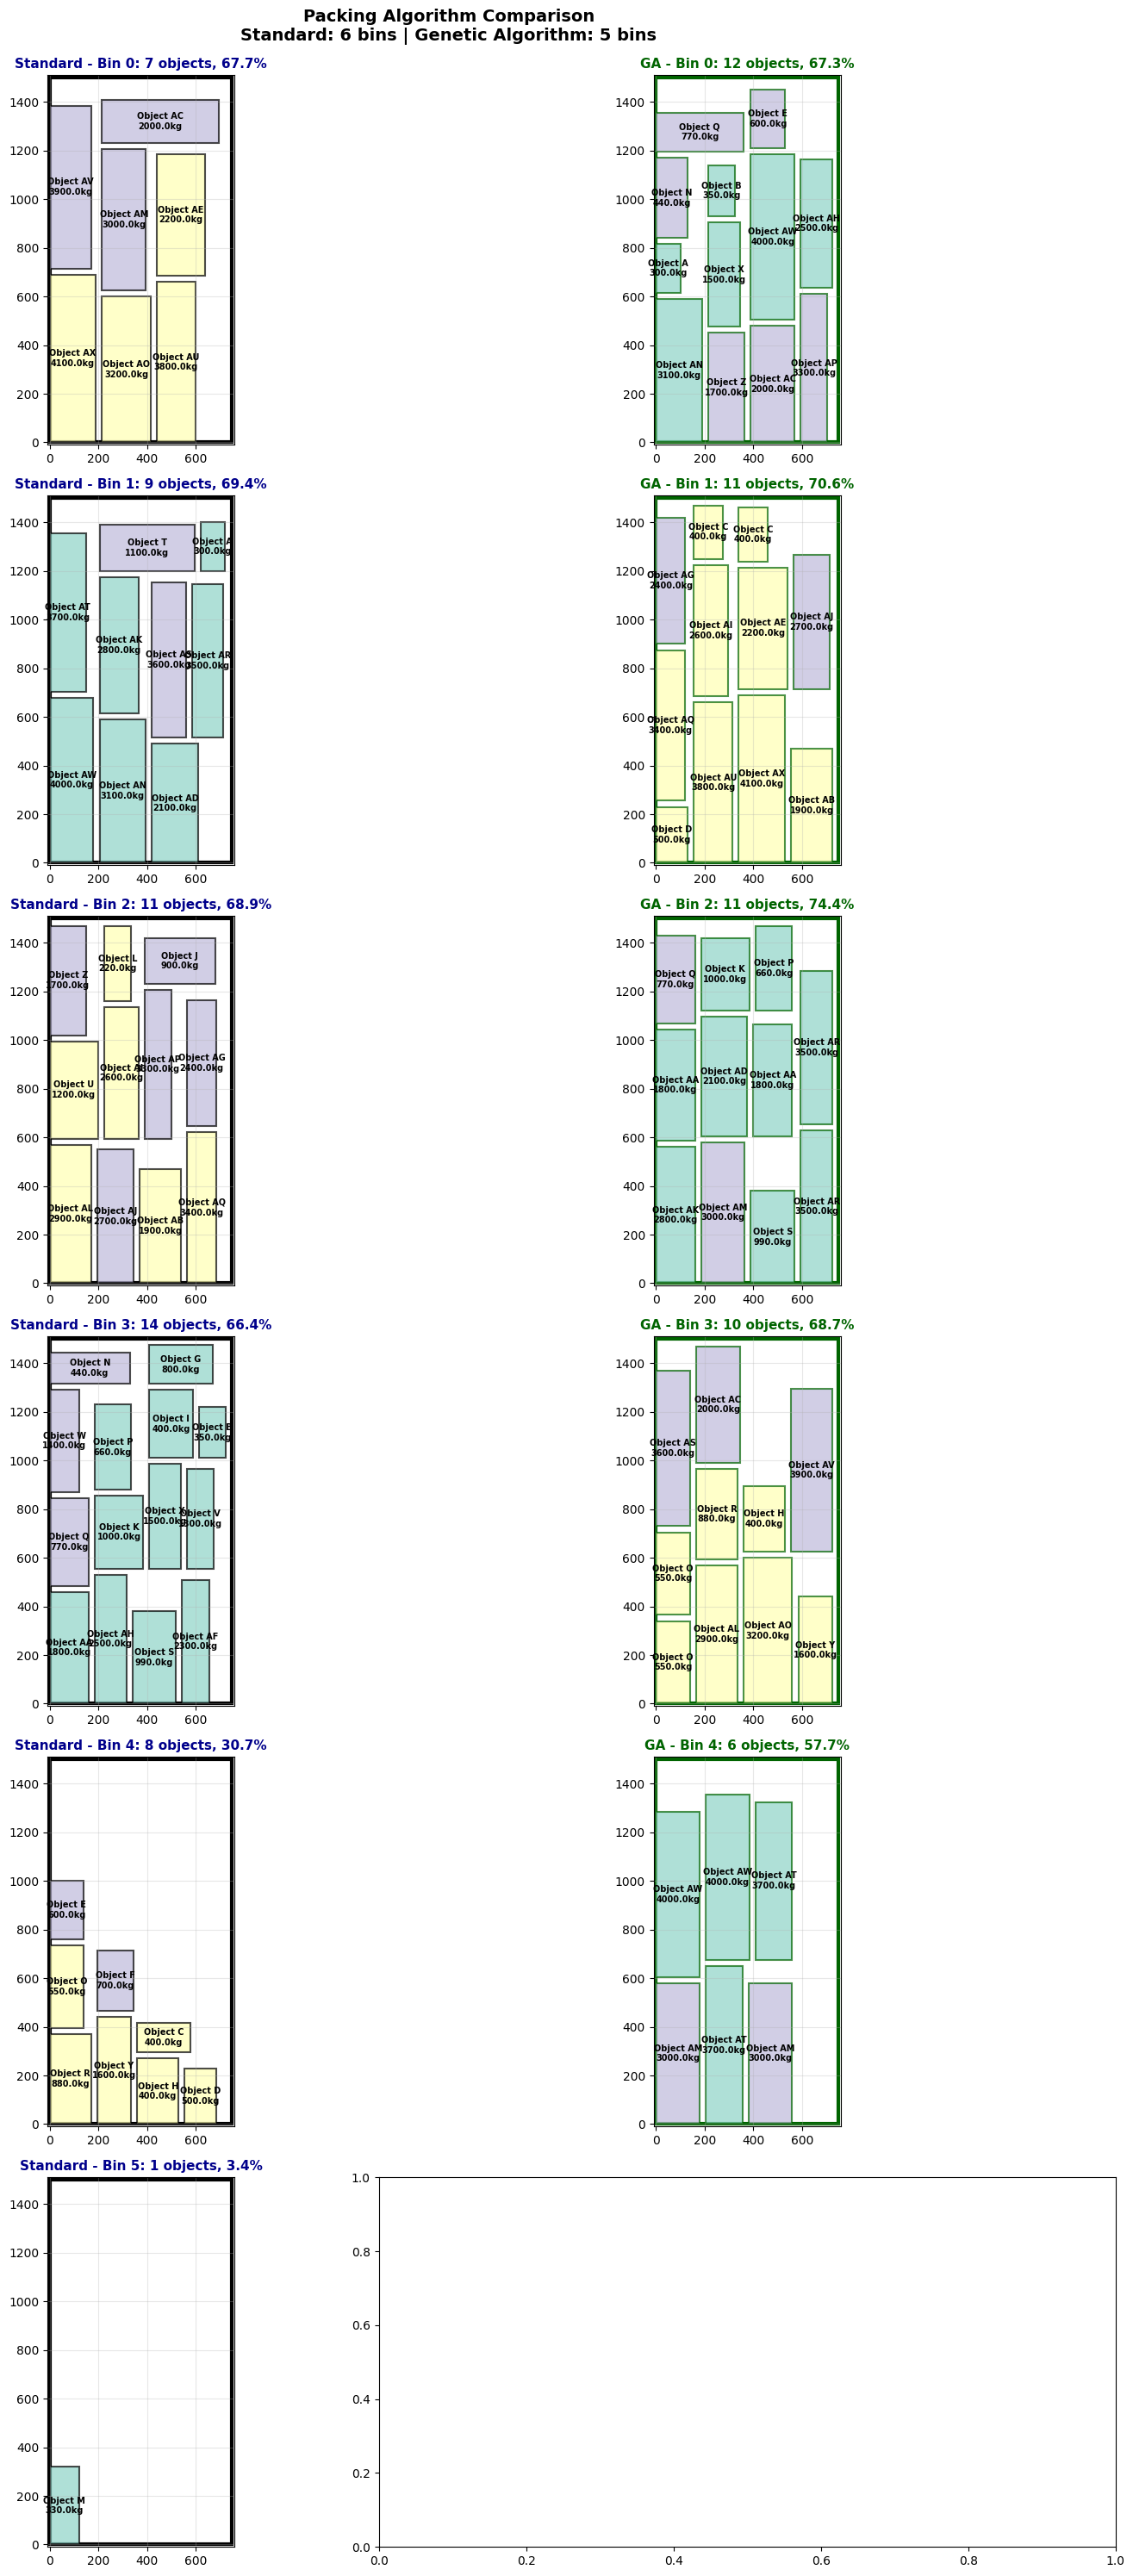

✓ Comparison visualization complete


In [16]:
# Visualize comparison
fig, axes = plt.subplots(
    max(len(bins_standard), len(bins_ga)), 
    2, 
    figsize=(16, 5 * max(len(bins_standard), len(bins_ga)))
)

if max(len(bins_standard), len(bins_ga)) == 1:
    axes = axes.reshape(1, -1)

categories = objects_df['category'].unique()
color_map = {cat: plt.cm.Set3(i) for i, cat in enumerate(categories)}

# Standard Packing
for bin_idx, bin_obj in enumerate(bins_standard):
    ax = axes[bin_idx, 0]
    
    # Draw bin boundary
    bin_rect = patches.Rectangle((0, 0), bin_obj.width, bin_obj.length, 
                                  linewidth=3, edgecolor='black', facecolor='none')
    ax.add_patch(bin_rect)
    
    # Draw objects
    stack_offset = {}
    for rect in bin_obj.rectangles:
        key = (rect.x, rect.y)
        if key not in stack_offset:
            stack_offset[key] = 0
        offset = stack_offset[key]
        stack_offset[key] += 2
        
        color = color_map.get(rect.category, 'gray')
        x = rect.x + offset
        y = rect.y + offset
        w = rect.get_width()
        l = rect.get_length()
        
        obj_rect = patches.Rectangle((x, y), w, l, 
                                     linewidth=1.5, edgecolor='black', 
                                     facecolor=color, alpha=0.7)
        ax.add_patch(obj_rect)
        
        label = f"{rect.obj_name}\n{rect.weight}kg"
        if rect.stack_height > 1:
            label += f"\n(x{rect.stack_height})"
        
        ax.text(x + w/2, y + l/2, label, ha='center', va='center', 
               fontsize=7, fontweight='bold')
    
    total_area = sum(rect.area() for rect in bin_obj.rectangles)
    utilization = (total_area / (bin_obj.width * bin_obj.length)) * 100
    
    ax.set_xlim(-10, bin_obj.width + 10)
    ax.set_ylim(-10, bin_obj.length + 10)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title(f'Standard - Bin {bin_idx}: {len(bin_obj.rectangles)} objects, {utilization:.1f}%', 
                fontsize=11, fontweight='bold', color='darkblue')

# GA Packing
for bin_idx, bin_obj in enumerate(bins_ga):
    ax = axes[bin_idx, 1]
    
    # Draw bin boundary
    bin_rect = patches.Rectangle((0, 0), bin_obj.width, bin_obj.length, 
                                  linewidth=3, edgecolor='darkgreen', facecolor='none')
    ax.add_patch(bin_rect)
    
    # Draw objects
    stack_offset = {}
    for rect in bin_obj.rectangles:
        key = (rect.x, rect.y)
        if key not in stack_offset:
            stack_offset[key] = 0
        offset = stack_offset[key]
        stack_offset[key] += 2
        
        color = color_map.get(rect.category, 'gray')
        x = rect.x + offset
        y = rect.y + offset
        w = rect.get_width()
        l = rect.get_length()
        
        obj_rect = patches.Rectangle((x, y), w, l, 
                                     linewidth=1.5, edgecolor='darkgreen', 
                                     facecolor=color, alpha=0.7)
        ax.add_patch(obj_rect)
        
        label = f"{rect.obj_name}\n{rect.weight}kg"
        if rect.stack_height > 1:
            label += f"\n(x{rect.stack_height})"
        
        ax.text(x + w/2, y + l/2, label, ha='center', va='center', 
               fontsize=7, fontweight='bold')
    
    total_area = sum(rect.area() for rect in bin_obj.rectangles)
    utilization = (total_area / (bin_obj.width * bin_obj.length)) * 100
    
    ax.set_xlim(-10, bin_obj.width + 10)
    ax.set_ylim(-10, bin_obj.length + 10)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title(f'GA - Bin {bin_idx}: {len(bin_obj.rectangles)} objects, {utilization:.1f}%', 
                fontsize=11, fontweight='bold', color='darkgreen')

# Hide extra subplots
for idx in range(max(len(bins_standard), len(bins_ga)), len(axes)):
    axes[idx, 0].axis('off')
    axes[idx, 1].axis('off')

plt.suptitle(f'Packing Algorithm Comparison\nStandard: {len(bins_standard)} bins | Genetic Algorithm: {len(bins_ga)} bins', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print('✓ Comparison visualization complete')

### 9.5 Metrics Chart

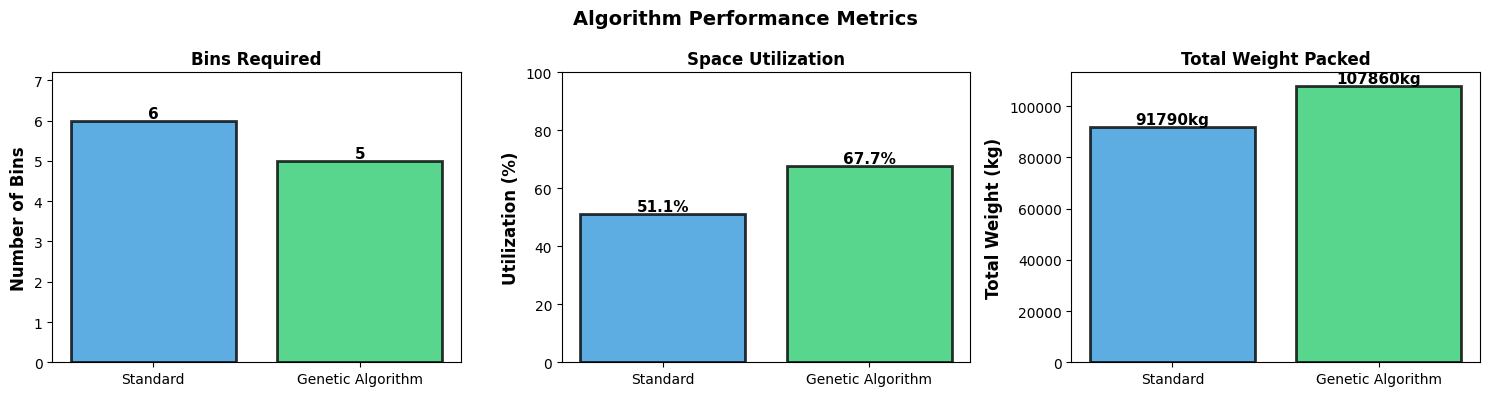

✓ Metrics charts complete


In [17]:
# Create comparison charts
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Chart 1: Number of Bins
algorithms = ['Standard', 'Genetic Algorithm']
bins_count = [standard_metrics['num_bins'], ga_metrics['num_bins']]
colors = ['#3498db', '#2ecc71']

bars1 = axes[0].bar(algorithms, bins_count, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Number of Bins', fontsize=12, fontweight='bold')
axes[0].set_title('Bins Required', fontsize=12, fontweight='bold')
axes[0].set_ylim(0, max(bins_count) * 1.2)
for i, bar in enumerate(bars1):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

# Chart 2: Utilization
utilization = [standard_metrics['avg_utilization'], ga_metrics['avg_utilization']]
bars2 = axes[1].bar(algorithms, utilization, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Utilization (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Space Utilization', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, 100)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

# Chart 3: Total Weight Distribution
weights = [standard_metrics['total_weight'], ga_metrics['total_weight']]
bars3 = axes[2].bar(algorithms, weights, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[2].set_ylabel('Total Weight (kg)', fontsize=12, fontweight='bold')
axes[2].set_title('Total Weight Packed', fontsize=12, fontweight='bold')
for i, bar in enumerate(bars3):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}kg',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.suptitle('Algorithm Performance Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('✓ Metrics charts complete')

## 10. Export Preferred Solution 

In [18]:
# SELECT AND EXPORT TO DXF
print("=== SELECT PACKING FOR DXF EXPORT ===\n")
print("Available packings:")
print("1. Standard Greedy Packing")
print("2. Genetic Algorithm Packing")
print("3. Compare both (side-by-side)")

choice = input("\nSelect (1, 2, or 3): ").strip()

if choice == '1':
    bins_to_export = bins_standard
    export_name = "Standard Greedy"
    print(f"\n✓ Selected: {export_name} ({len(bins_to_export)} bins)")
elif choice == '2':
    bins_to_export = bins_ga
    export_name = "Genetic Algorithm"
    print(f"\n✓ Selected: {export_name} ({len(bins_to_export)} bins)")
elif choice == '3':
    print("\nShowing comparison visualization...")
    # Show comparison and let user choose after
    choice = input("\nAfter viewing comparison, select (1 or 2): ").strip()
    if choice == '1':
        bins_to_export = bins_standard
        export_name = "Standard Greedy"
    else:
        bins_to_export = bins_ga
        export_name = "Genetic Algorithm"
    print(f"\n✓ Selected: {export_name} ({len(bins_to_export)} bins)")
else:
    print("Invalid choice! Defaulting to Genetic Algorithm")
    bins_to_export = bins_ga
    export_name = "Genetic Algorithm"
    print(f"\n✓ Selected: {export_name} ({len(bins_to_export)} bins)")

# User input for bin spacing in DXF
bin_spacing_input = input("Enter spacing between bins in DXF (default 5): ").strip()

try:
    bin_spacing = float(bin_spacing_input) if bin_spacing_input else 5
except ValueError:
    print("Invalid input! Using default: 5")
    bin_spacing = 5

print(f"✓ Using bin spacing: {bin_spacing}\n")

# Generate DXF
print(f"\nGenerating DXF for: {export_name}")

doc = ezdxf.new()
msp = doc.modelspace()

#bin_spacing = 5  # Space between bins in DXF

y_offset = 0
for bin_idx, bin_obj in enumerate(bins_to_export):
    bin_x = 0
    bin_y = y_offset
    
    # Draw bin boundary
    msp.add_lwpolyline([
        (bin_x, bin_y), 
        (bin_x + bin_obj.width, bin_y), 
        (bin_x + bin_obj.width, bin_y + bin_obj.length), 
        (bin_x, bin_y + bin_obj.length), 
        (bin_x, bin_y)
    ], close=True)
    
    stack_offset = {}
    for rect in bin_obj.rectangles:
        key = (rect.x, rect.y)
        if key not in stack_offset:
            stack_offset[key] = 0
        offset = stack_offset[key]
        stack_offset[key] += 0.5
        
        x = bin_x + rect.x + offset
        y = bin_y + rect.y + offset
        w = rect.get_width()
        l = rect.get_length()
        
        # Draw rectangle
        msp.add_lwpolyline([
            (x, y), 
            (x + w, y), 
            (x + w, y + l), 
            (x, y + l), 
            (x, y)
        ], close=True)
        
        # Add MTEXT
        label = f"{rect.obj_name}\\P{rect.weight}kg\\P{rect.category}"
        if rect.stack_height > 1:
            label += f"\\P(Stack: {rect.stack_height}x)"
        
        mtext = msp.add_mtext(label, dxfattribs={'char_height': 2})
        mtext.set_location((x + w/2, y + l/2), None,5) #5 = center alignment
    
    # Move to next bin position (add spacing HERE)
    y_offset += bin_obj.length + bin_spacing

# Save DXF
os.makedirs('../data', exist_ok=True)
filename = f'../data/optimized_laydown_{export_name.replace(" ", "_").lower()}.dxf'
doc.saveas(filename)

print(f'\n✓ DXF generated: {filename}')
print(f'  Algorithm: {export_name}')
print(f'  Bins: {len(bins_to_export)}')
print(f'  Objects: {sum(len(bin.rectangles) for bin in bins_to_export)}')

# Summary
for i, bin_obj in enumerate(bins_to_export):
    total_area = sum(rect.area() for rect in bin_obj.rectangles)
    utilization = (total_area / (bin_obj.width * bin_obj.length)) * 100
    categories_in_bin = set(rect.category for rect in bin_obj.rectangles)
    print(f'\n  Bin {i}: {len(bin_obj.rectangles)} objects, {utilization:.1f}% utilization')
    print(f'    Categories: {", ".join(categories_in_bin)}')

=== SELECT PACKING FOR DXF EXPORT ===

Available packings:
1. Standard Greedy Packing
2. Genetic Algorithm Packing
3. Compare both (side-by-side)

Showing comparison visualization...

✓ Selected: Genetic Algorithm (5 bins)
✓ Using bin spacing: 50.0


Generating DXF for: Genetic Algorithm

✓ DXF generated: ../data/optimized_laydown_genetic_algorithm.dxf
  Algorithm: Genetic Algorithm
  Bins: 5
  Objects: 50

  Bin 0: 12 objects, 67.3% utilization
    Categories: Category 1, Category 3

  Bin 1: 11 objects, 70.6% utilization
    Categories: Category 3, Category 2

  Bin 2: 11 objects, 74.4% utilization
    Categories: Category 1, Category 3

  Bin 3: 10 objects, 68.7% utilization
    Categories: Category 3, Category 2

  Bin 4: 6 objects, 57.7% utilization
    Categories: Category 1, Category 3
